# Analyzing reuse of posters

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from urllib.parse import unquote
import re
import os
import json
from scipy import stats
import time
from collections import Counter
import pandas as pd
import numpy as np
import json
from datetime import datetime
from pathlib import Path
from scipy import stats
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

## Global helper functions

In [17]:
_DOI_PATTERN = re.compile(
    r"""
    (?P<doi>                                  # capture group "doi"
        10\.\d{4,9}                           # directory indicator: 10.<4-9 digits>
        /                                     # slash
        [^\s"'<>\]]+                          # suffix: anything except whitespace/quotes/brackets
    )
    """,
    re.IGNORECASE | re.VERBOSE,
)

# Normalize dois, makes it easier to deduplicate citations
def _norm_doi(s):
    
    if not isinstance(s, str):
        return ""

    # Strip whitespace and decode any %-escapes first (handles %2F etc.)
    s_clean = unquote(s.strip())
    if not s_clean:
        return ""

    # Work in lowercase for stable matching
    s_lower = s_clean.lower()
    
    # Search for a DOI substring anywhere in the string
    m = _DOI_PATTERN.search(s_lower)
    if not m:
        return ""

    doi = m.group("doi").strip()

    return doi

## Create combined metadata file for reuse analysis

In [18]:
def finalize_df(df):
    
    bool_cols = [c for c in df.columns if c.startswith("has_") or c.startswith("is_")]
    count_cols = [c for c in df.columns if c.endswith("_count")]
    float_cols = [c for c in df.columns if c.endswith("_percentage")]
    str_cols = [
        "doi", "doi_url", "doi_norm", "repository_url", "license_name",
        "creation_date", "other_dates", "files", "repository"
    ]
    year_cols = ["creation_year"]

    # Ensure columns exist
    for c in str_cols + bool_cols + count_cols + float_cols:
        if c not in df.columns:
            df[c] = pd.NA

    df[bool_cols] = df[bool_cols].astype("boolean")
    df[count_cols] = df[count_cols].astype("Int64")
    df[float_cols] = df[float_cols].astype("Float64")
    df[str_cols] = df[str_cols].astype("string")
    df[year_cols] = df[year_cols].astype("Int64")

    # views/downloads int
    for c in ["views", "downloads", "citations"]:
        if c in df.columns:
            df[c] = df[c].astype("Int64")

    return df

In [19]:
# Load Data
df_zenodo = pd.read_csv("inputs/dataset/derivative/poster-metadata/zenodo.csv")
df_figshare = pd.read_csv("inputs/dataset/derivative/poster-metadata/figshare.csv")

# Combine and add normalized doi (better for comparison)
df = pd.concat([df_zenodo, df_figshare], ignore_index=True)
df['doi_norm'] = df['doi'].apply(_norm_doi).replace("", np.nan)

# Zenodo and Fishare subsets
zenodo_all = df[df['repository'] == 'Zenodo']
figshare_all = df[df['repository'] == 'Figshare']

# Open access count
def get_oa_info(subset):
    count = subset['is_open_access'].sum() if 'is_open_access' in subset.columns else 0
    pct = (count / len(subset) * 100) if len(subset) > 0 else 0
    return count, pct

z_oa_count, z_oa_pct = get_oa_info(zenodo_all)
f_oa_count, f_oa_pct = get_oa_info(figshare_all)

# DOI verification
z_with_doi = zenodo_all[zenodo_all['doi_norm'].notna()]
z_no_doi = zenodo_all[zenodo_all['doi_norm'].isna()]
z_dupes = z_with_doi[z_with_doi['doi_norm'].duplicated(keep=False)]

f_with_doi = figshare_all[figshare_all['doi_norm'].notna()]
f_no_doi = figshare_all[figshare_all['doi_norm'].isna()]
f_dupes = f_with_doi[f_with_doi['doi_norm'].duplicated(keep=False)]

# Final records to keep for reuse analysis (open access, no duplicate DOIs)
df_figshare_final = f_with_doi[f_with_doi['is_open_access'] == True].drop_duplicates(subset='doi_norm', keep='first')

z_also_in_f = z_with_doi[z_with_doi['doi_norm'].isin(df_figshare_final['doi_norm'])]
df_zenodo_final = z_with_doi[
    (z_with_doi['is_open_access'] == True) & 
    (~z_with_doi['doi_norm'].isin(df_figshare_final['doi_norm'])) #remove DOIs already in Figshare
].drop_duplicates(subset='doi_norm', keep='first')

# Combine
df_final = pd.concat([df_figshare_final, df_zenodo_final], ignore_index=True)
df_final = finalize_df(df_final)

# Save the final cleaned dataframe (not the original 'df')
df_final.to_csv("outputs/poster-reuse/combined-metadata.csv", index=False)

# Summary
z_retention = (len(df_zenodo_final) / len(zenodo_all) * 100) if len(zenodo_all) > 0 else 0
f_retention = (len(df_figshare_final) / len(figshare_all) * 100) if len(figshare_all) > 0 else 0

print(f"--- Zenodo Reporting ---")
print(f"Total records: {len(zenodo_all)}")
print(f"Open Access: {z_oa_count} ({z_oa_pct:.1f}%)")
print(f"With DOI: {len(z_with_doi)} | No DOI: {len(z_no_doi)}")
print(f"Records with duplicate DOIs: {len(z_dupes)}")
print(f"DOIs already in Figshare: {len(z_also_in_f)}")
print(f"RETAINED in Final: {len(df_zenodo_final)} ({z_retention:.1f}%)")

print(f"\n--- Figshare Reporting ---")
print(f"Total records: {len(figshare_all)}")
print(f"Open Access: {f_oa_count} ({f_oa_pct:.1f}%)")
print(f"With DOI: {len(f_with_doi)} | No DOI: {len(f_no_doi)}")
print(f"Records with duplicate DOIs: {len(f_dupes)}")
print(f"RETAINED in Final: {len(df_figshare_final)} ({f_retention:.1f}%)")

total_retention = (len(df_final) /(len(zenodo_all) + len(figshare_all)) * 100) 
print(f"\n--- Combined Output ---")
print(f"Total records in final CSV: {len(df_final)} ({total_retention:.1f}%)")
display(df_final.head(5))
df = df_final.copy()

--- Zenodo Reporting ---
Total records: 24734
Open Access: 24340 (98.4%)
With DOI: 24714 | No DOI: 20
Records with duplicate DOIs: 2
DOIs already in Figshare: 15
RETAINED in Final: 24304 (98.3%)

--- Figshare Reporting ---
Total records: 14387
Open Access: 14387 (100.0%)
With DOI: 13843 | No DOI: 544
Records with duplicate DOIs: 0
RETAINED in Final: 13843 (96.2%)

--- Combined Output ---
Total records in final CSV: 38147 (97.5%)


,doi,doi_url,repository_url,is_open_access,authors_count,authors_affiliation_count,authors_familyname_count,authors_givennames_count,authors_gnd_count,authors_name_count,...,has_title,has_version,has_description,description_words_count,description_characters_count,files,views,downloads,repository,doi_norm
0,10.6084/m9.figshare.12685880.v1,https://doi.org/10.6084/m9.figshare.12685880.v1,https://2020cigtectonics.figshare.com/articles...,True,4,0,0,0,0,4,...,True,True,True,102,604,Morrow_CIGTect2020_aMoreResponsiveM.pdf,910,279,Figshare,10.6084/m9.figshare.12685880.v1
1,10.6084/m9.figshare.12674222.v1,https://doi.org/10.6084/m9.figshare.12674222.v1,https://2020cigtectonics.figshare.com/articles...,True,3,0,0,0,0,3,...,True,True,True,74,458,CIG-Shear_zone_formation.pdf,1436,530,Figshare,10.6084/m9.figshare.12674222.v1
2,10.6084/m9.figshare.12728639.v1,https://doi.org/10.6084/m9.figshare.12728639.v1,https://2020cigtectonics.figshare.com/articles...,True,1,0,0,0,0,1,...,True,True,True,8,53,CIG2020_sandiford.pdf,643,170,Figshare,10.6084/m9.figshare.12728639.v1
3,10.6084/m9.figshare.12678296.v1,https://doi.org/10.6084/m9.figshare.12678296.v1,https://2020cigtectonics.figshare.com/articles...,True,6,0,0,0,0,6,...,True,True,True,40,245,poster_final.pdf,950,303,Figshare,10.6084/m9.figshare.12678296.v1
4,10.6084/m9.figshare.12673700.v1,https://doi.org/10.6084/m9.figshare.12673700.v1,https://2020cigtectonics.figshare.com/articles...,True,3,0,0,0,0,3,...,True,True,True,178,1036,HeFengCIGPoster.tif,742,208,Figshare,10.6084/m9.figshare.12673700.v1


## Helper functions for citation count

In [5]:
# Get normalized doi url
def _norm_doi_url(s):
    doi_id = _norm_doi(s)
    if not doi_id:
        return ""
    return f"https://doi.org/{doi_id}"

#get OA record given DOI:
def get_oa_record(doi, email = None, api_key = None):
    target_doi = _norm_doi(doi)
    if not target_doi:
        raise ValueError(f"Invalid DOI: {doi}")
    work_lookup = f"https://api.openalex.org/works/{_norm_doi_url(target_doi)}"
    if email:
        work_lookup += f"?mailto={email}"
    r = requests.get(work_lookup, timeout=60)
    r.raise_for_status()   # raise on ANY HTTP error

    record = r.json()
    return record


# Get citations given an OA id
def get_all_citing_works_oa(openalex_id, email=None):
    results = []
    cursor = "*"

    while True:
        url = f"https://api.openalex.org/works?filter=cites:{openalex_id}&per-page=200&cursor={cursor}"
        if email:
            url += f"&mailto={email}"

        try:
            r = requests.get(url, timeout=60)
            r.raise_for_status()
        except requests.Timeout:
            raise

        data = r.json()
        results.extend(data["results"])

        cursor = data["meta"]["next_cursor"]
        if not cursor:
            break
        
        time.sleep(0.5)

    return results

# Get OA citations given a DOI
def find_citations_oa(doi, email = None, api_key = None):
    target_doi = _norm_doi(doi)
    if not target_doi:
        raise ValueError(f"Invalid DOI: {doi}")

    record = get_oa_record(doi, email, api_key)

    try:
        openalex_id_url = record["id"]
        cited_by_count = record["cited_by_count"]
    except KeyError as e:
        raise KeyError(f"Missing expected OpenAlex field: {e}") from e

    if not cited_by_count:
        return []  # no citations

    if not isinstance(openalex_id_url, str) or "/" not in openalex_id_url:
        raise ValueError(f"Malformed OpenAlex id: {openalex_id_url}")

    openalex_id = openalex_id_url.rsplit("/", 1)[-1]

    # Get all citing works
    citing_records = get_all_citing_works_oa(openalex_id, email=email)

    results = []
    for c in citing_records:
        doi_raw = c.get("doi") or ""
        citation_link = _norm_doi_url(doi_raw) or c.get("id", "")

        citation_date_raw = c.get("publication_date") or ""
        try:
            citation_year = int(citation_date_raw[:4]) if citation_date_raw else ""       
        except (ValueError, TypeError):
            citation_year = ""

        if citation_link:
            rec = {
                "poster_doi": doi,
                "source": ["openalex"],
                "citation_link": citation_link,
            }
            if citation_year:
                rec["citation_year"] = citation_year
                rec["citation_year_source"] = "openalex"
            
            citation_type = c.get("type", "")
            if citation_type:
                rec["citation_type"] = citation_type
                rec["citation_type_source"] = "openalex"
                
            results.append(rec)    

    return results

# Get DataCite record for a doi
def get_datacite_record(doi, timeout = 30):
    target_doi = _norm_doi(doi)
    if not target_doi:
        raise ValueError(f"Invalid DOI: {doi}")
    url = f"https://api.datacite.org/dois/{target_doi}"
    r = requests.get(url, timeout=timeout)
    r.raise_for_status()
    record  = r.json()
    return record
    
# Get citation list from Datacite
def find_citations_datacite(doi, timeout = 30):    
    record  = get_datacite_record(doi, timeout)
    citations = (
    record.get("data", {})
          .get("relationships", {})
          .get("citations", {})
          .get("data", [])
    )
    
    results = []
    for item in citations:
        citation_id = item["id"]
        citation_link = _norm_doi_url(citation_id) or citation_id
        rec = {
            "poster_doi": doi,
            "source": ["datacite"],
            "citation_link": citation_link,
        }
        results.append(rec)
    
    return results

def get_crossref_record(doi, timeout = 30):
    target_doi = _norm_doi(doi)
    if not target_doi:
        raise ValueError(f"Invalid DOI: {doi}")    
    url = f"https://api.crossref.org/works/{target_doi}"
    r = requests.get(url, timeout=timeout)
    r.raise_for_status()
    record  = r.json()   
    return record

# Get publication year
def get_publication_info(doi, email = None, api_key = None):
    
    target_doi = _norm_doi(doi)
    if not target_doi:
        raise ValueError(f"Invalid DOI: {doi}") 
        
    # Try OA first
    try:
        record = get_oa_record(target_doi, email=email, api_key=api_key)
        pub_date = record.get("publication_date")
        citation_type = record.get("type")
        info = {}
        if pub_date and len(pub_date) >= 4:
            info["citation_year"] = int(pub_date[:4])
            info["citation_year_source"] = "openalex"
        if citation_type:
            info["citation_type"] = citation_type
            info["citation_type_source"] = "openalex"
        if info:
            return info
    except (requests.HTTPError, KeyError, ValueError, TypeError):
        pass
    
    # Then try CrossRef
    try:
        record = get_crossref_record(target_doi)
        date_parts = record["message"].get("created", {}).get("date-parts", [])
        if date_parts and len(date_parts[0]) > 0:
            year = date_parts[0][0]
        citation_type = record["message"].get("type", "")
        info = {}
        if year:
            info["citation_year"] = int(year)
            info["citation_year_source"] = "crossref"
        if citation_type:
            info["citation_type"] = citation_type
            info["citation_type_source"] = "crossref"
        if info:
            return info
    except (requests.HTTPError, KeyError, ValueError, TypeError):
        pass
    
    # Finally try DataCite
    try:
        record = get_datacite_record(target_doi)
        data_dict = record.get("data", {})
        attributes = data_dict.get("attributes", {})
        year = attributes.get("publicationYear")
        citation_type = attributes.get("types", {}).get("resourceType")
        info = {}
        if year:
            info["citation_year"] = int(year)
            info["citation_year_source"] = "datacite"
        if citation_type:
            info["citation_type"] = citation_type
            info["citation_type_source"] = "datacite"
        if info:
            return info
    except (requests.HTTPError, KeyError, ValueError, TypeError):
        pass
    
    
    return ""

def find_citations(doi, email=None, api_key=None):
        
    # 1) OA 
    try:
        results_oa = find_citations_oa(doi, email, api_key)
    except requests.HTTPError as e:
        if e.response is not None and e.response.status_code == 404:
            results_oa = [] 
        else:
            raise  

    # 2) DataCite 
    try:
        results_dc = find_citations_datacite(doi)
    except requests.HTTPError as e:
        if e.response is not None and e.response.status_code == 404:
            results_dc = [] #(404 => no DC record => no DC citations)
        else:
            raise  # real DC error
            
    # 3) Deduplicate OA results + index for fast deduplication
    results = []
    index = {}

    for rec in results_oa:
        link = rec.get("citation_link")
        key = link

        # keep on first occurrence in case there are duplicated in oa citations list
        if key in index:
            continue
        index[key] = len(results)
        results.append(rec)

    # 4) Add DataCite citations
    for dc in results_dc:
        link = dc.get("citation_link")
        key = link

        if key in index:
            # already exists: then add datacite to "source" list
            i = index[key]
            results[i]["source"] = sorted(set(results[i]["source"]) | {"datacite"}) #makes sure datacite only added once even if the citation is duplicated in the datacite list
            continue

        # new citation from DataCite
        new_rec = {
            "poster_doi": dc.get("poster_doi"),
            "source": ["datacite"],
            "citation_link": link,
        }

        # if it's a DOI, try OA lookup for year and citation type
        if _norm_doi(link):
            info = get_publication_info(link, email, api_key)
            if info:
                year = info.get("citation_year")
                if year:
                    new_rec["citation_year"] = year
                    new_rec["citation_year_source"] = info["citation_year_source"]
                citation_type = info.get("citation_type")
                if citation_type:
                    new_rec["citation_type"] = citation_type
                    new_rec["citation_type_source"] = info["citation_type_source"]
                    
        index[key] = len(results)
        results.append(new_rec)
    
    return results

# load completed DOIs
def _load_done_set(done_path):
    done = set()
    if not os.path.exists(done_path):
        return done
    with open(done_path, "r", encoding="utf-8") as f:
        for line in f:
            d = line.strip()
            if d:
                done.add(d)
    return done

# save completed DOIs
def _append_done(done_path, doi):
    os.makedirs(os.path.dirname(done_path), exist_ok=True)

    with open(done_path, "a", encoding="utf-8") as f:
        f.write(doi + "\n")
        f.flush()
        os.fsync(f.fileno())

# save citation results to file
def _append_ndjson(path, records):
    os.makedirs(os.path.dirname(path), exist_ok=True)

    n = 0
    with open(path, "a", encoding="utf-8") as f:
        for rec in records:
            f.write(json.dumps(rec, ensure_ascii=False) + "\n")
            n += 1
        f.flush()
        os.fsync(f.fileno())
    return n

def run_find_citations_for_df(
    df,
    *,
    doi_col,
    out_ndjson,
    done_path,
    error_ndjson,
    email = None,
    api_key = None,
    normalize_done_key = False,
) -> dict:
    """
    Runs find_citations() for every DOI in df[doi_col], appends all citation records
    to out_ndjson, and records successfully processed DOIs in done_path

    - Skips missing/blank/NaN DOIs.
    - Skips DOIs already in done_path.
    - Logs failures to error_ndjson and continue
    """
    if doi_col not in df.columns:
        raise KeyError(f"Missing column '{doi_col}' in df")

    # Load already done
    done = _load_done_set(done_path)
    
    # Summary of current state
    valid_dois_to_process = []
    skipped_missing = 0
    skipped_done = 0
    total_posters = len(df)
    
    # Calculate total posters with DOI
    all_normalized_dois = []
    for raw in df[doi_col]:
        doi = _norm_doi(raw)
        if not doi:
            skipped_missing += 1
        else:
            all_normalized_dois.append(doi)
            if doi in done:
                skipped_done += 1
            else:
                valid_dois_to_process.append((raw, doi))

    total_posters_with_doi = len(all_normalized_dois)
    total_to_process_session = len(valid_dois_to_process)


    # Iterate only over the remaining DOIs
    succeeded_session = 0
    failed_session = 0
    citations_session = 0
    print(f"--- Session overview ---")
    print(f"Total posters: {total_posters}")
    print(f"Total with DOI: {total_posters_with_doi}")
    print(f"Already processed: {skipped_done}")
    print(f"Remaining for session: {total_to_process_session}")
    
    print(f"\n--- Starting session ---")
    for raw_doi, norm_doi in valid_dois_to_process:
        try:
            records = find_citations(norm_doi, email=email, api_key=api_key) or []
            count_added = _append_ndjson(out_ndjson, records)
            citations_session += count_added
            
            _append_done(done_path, norm_doi)
            done.add(norm_doi)
            succeeded_session += 1

        except Exception as e:
            failed_session += 1
            err_rec = {
                "poster_doi": raw_doi,
                "poster_doi_norm": norm_doi,
                "error_type": type(e).__name__,
                "error": str(e),
            }
            _append_ndjson(error_ndjson, [err_rec])
            
        current_done = succeeded_session + failed_session
        msg = (
            f"\rProgress: {current_done}/{total_to_process_session} | "
            f"Session Citations: {citations_session} | "
            f"Session Errors: {failed_session} "
        )

        print(msg, end="", flush=True)
        time.sleep(0.5)
        
    # Final summary
    total_processed_success = skipped_done + succeeded_session
    total_processed_errors = failed_session 
    total_processed_session = succeeded_session + failed_session
    
    return {
        "total_posters": total_posters,
        "total_posters_with_doi": total_posters_with_doi,
        "total_processed_with_success": total_processed_success,
        "total_processed_with_errors": total_processed_errors,
        "total_processed_in_this_session": total_processed_session,
        "total_citations_found_session": citations_session, 
    }

## Collect citation data

### Get citations from OpenAlex and DataCite for posters with DOI

In [6]:
out_ndjson= "outputs/citations/posters-citations.ndjson"
done_path = "outputs/citations/posters-citations.done.txt"
error_ndjson = "outputs/citations/posters-citations.errors.ndjson"

summary = run_find_citations_for_df(
    df,
    doi_col = "doi",
    out_ndjson = out_ndjson,
    done_path = done_path,
    error_ndjson = error_ndjson,
    email = "bpatel@calmi2.org"    
)
display(summary)

--- Session overview ---
Total posters: 38147
Total with DOI: 38147
Already processed: 38147
Remaining for session: 0

--- Starting session ---


{'total_posters': 38147,
 'total_posters_with_doi': 38147,
 'total_processed_with_success': 38147,
 'total_processed_with_errors': 0,
 'total_processed_in_this_session': 0,
 'total_citations_found_session': 0}

### Remove false positive (citation date < published date

### Citation harvesting overview

In [20]:
def analyze_citations(file_path):
    
    def get_stat(count):
        pct = (count / total * 100) if total > 0 else 0
        return f"{count} ({pct:.1f}%)"
    
    def fmt(count):
            pct = (count / total * 100)
            return f"{count} ({pct:.1f}%)"
    
    # Load the NDJSON file into a df
    df = pd.read_json(file_path, lines=True)

    # Total number of citations
    total = len(df)
    
    # Duplicates
    duplicate_mask = df.duplicated(subset=['poster_doi', 'citation_link'], keep=False)
    df_duplicates = df[duplicate_mask]
    
    # count_duplicates: Total rows involved in a duplicate relationship
    # count_extra_rows: Number of rows that would be removed if we ran drop_duplicates
    count_extra_rows = df.duplicated(subset=['poster_doi', 'citation_link']).sum()
    print(f"Duplicate Citation Pairs (extra rows): {get_stat(count_extra_rows)}")
    if count_extra_rows > 0:
        print("Duplicates:")
        print(df_duplicates.groupby(['poster_doi', 'citation_link']).size().sort_values(ascending=False))
    
    # Source
    df['from_openalex'] = df['source'].apply(lambda x: 'openalex' in x)
    df['from_datacite'] = df['source'].apply(lambda x: 'datacite' in x)

    count_oa = df['from_openalex'].sum()
    count_unique_oa = df[df['source'].apply(lambda x: sorted(x) == ['openalex'])].shape[0]

    count_dc = df['from_datacite'].sum()
    count_unique_dc = df[df['source'].apply(lambda x: sorted(x) == ['datacite'])].shape[0]

    count_both = df[df['from_openalex'] & df['from_datacite']].shape[0]

    # Citations with a citation_year
    citations_with_year = df['citation_year'].notna().sum()
    

    # Distribution of citation_year_source
    year_source_counts = df['citation_year_source'].value_counts(dropna=True)
    year_source_pcts = (year_source_counts / total * 100)
    year_source_dist = pd.DataFrame({
        'Count': year_source_counts,
        'Percentage': year_source_pcts.map('{:.1f}%'.format)
    })


    print(f"Total Citations: {total}")
    print(f"Found via OpenAlex: {get_stat(count_oa)}")
    print(f"Unique to OpenAlex: {get_stat(count_unique_oa)}")
    print(f"Found via DataCite: {get_stat(count_dc)}")
    print(f"Unique to DataCite: {get_stat(count_unique_dc)}")
    print(f"Found via Both:     {get_stat(count_both)}")
    print(f"\nCitations with a citation year available: {fmt(citations_with_year)}")
    print(f"\nDistribution of 'citation_year_source':")
    print(year_source_dist)

analyze_citations(out_ndjson)

Duplicate Citation Pairs (extra rows): 0 (0.0%)
Total Citations: 19756
Found via OpenAlex: 19087 (96.6%)
Unique to OpenAlex: 19054 (96.4%)
Found via DataCite: 702 (3.6%)
Unique to DataCite: 669 (3.4%)
Found via Both:     33 (0.2%)

Citations with a citation year available: 19736 (99.9%)

Distribution of 'citation_year_source':
                      Count Percentage
citation_year_source                  
openalex              19711      99.8%
crossref                 18       0.1%
datacite                  7       0.0%


### Add citations count to metadata table

In [23]:
out_ndjson= "outputs/citations/posters-citations.ndjson"
df_cit = pd.read_json(out_ndjson, lines=True)

# Count citations per poster DOI
cit_counts = df_cit.groupby("poster_doi").size()  

# Add citation count column to metadata (0 if no match or no DOI)
df["citations"] = df["doi_norm"].map(cit_counts).fillna(0).astype("Int64")
print(f"Added {df['citations'].sum()} citations to the table")
df.to_csv("outputs/poster-reuse/combined-metadata.csv", index=False)


Added 19756 citations to the table


,doi,doi_url,repository_url,is_open_access,authors_count,authors_affiliation_count,authors_familyname_count,authors_givennames_count,authors_gnd_count,authors_name_count,...,has_version,has_description,description_words_count,description_characters_count,files,views,downloads,repository,doi_norm,citations
0,10.6084/m9.figshare.9895940.v1,https://doi.org/10.6084/m9.figshare.9895940.v1,https://figshare.com/articles/poster/TripleSlo...,True,1,0,0,0,0,1,...,True,True,109,627,triplesLogs-demo_poster.pdf,157,57,Figshare,10.6084/m9.figshare.9895940.v1,0
1,10.25376/hra.7798790.v1,https://doi.org/10.25376/hra.7798790.v1,https://hra.figshare.com/articles/poster/Targe...,True,4,0,0,0,0,4,...,True,True,316,1814,Poster SNIP 2018.pdf,0,0,Figshare,10.25376/hra.7798790.v1,0
2,10.6084/m9.figshare.11632647.v1,https://doi.org/10.6084/m9.figshare.11632647.v1,https://figshare.com/articles/poster/A_stateme...,True,1,0,0,0,0,1,...,True,True,22,124,P010.pdf,139,29,Figshare,10.6084/m9.figshare.11632647.v1,0
3,10.6084/m9.figshare.21069838.v1,https://doi.org/10.6084/m9.figshare.21069838.v1,https://figshare.com/articles/poster/An_lisis_...,True,2,0,0,0,0,2,...,True,True,10,62,Cartel Vía de los Polioles.pdf,281,61,Figshare,10.6084/m9.figshare.21069838.v1,0
4,10.6084/m9.figshare.12156945.v1,https://doi.org/10.6084/m9.figshare.12156945.v1,https://tagc2020.figshare.com/articles/poster/...,True,1,0,0,0,0,1,...,True,True,32,195,TAGC Poster 2020 Mefford.pdf,0,0,Figshare,10.6084/m9.figshare.12156945.v1,0


# Poster Metadata Quality and Engagement Analysis

**Pre-computed results** generated by executing poster_reuse_analysis.py are saved in outputs/analysis_results/ and are subsequently loaded in this notebook

## Table of Contents
1. [Setup and Data Loading](#1-setup)
2. [Citation Data Cleaning](#2-citation-cleaning)
3. [Descriptive Statistics](#3-descriptive)
4. [Temporal Distribution Visualizations](#4-temporal)
5. [Engagement Concentration Analysis](#5-concentration)
6. [Bivariate Analysis](#6-bivariate)
7. [Multivariate Analysis & Model Selection](#7-multivariate)
8. [Summary of Key Findings](#8-summary)

<a name="1-setup"></a>
## 1. Setup and Data Loading

### 1.1 Import Required Libraries

In [12]:
plt.rcParams.update({'font.family': 'sans-serif', 'font.size': 12, 'figure.dpi': 100})
RESULTS_DIR = Path("outputs/analysis_results")
print(f"Analysis notebook initialized: {datetime.now()}")

Analysis notebook initialized: 2026-02-12 16:37:01.434984


### 1.2 Load Pre-computed Analysis Results

The main dataset contains 38,147 poster records from Zenodo and Figshare with metadata fields and engagement metrics.

In [24]:
df_ = pd.read_csv(RESULTS_DIR / "combined-table-analyzed.csv", low_memory=False)
print(f"Dataset: {df.shape[0]:,} posters x {df.shape[1]} columns")
print(f"Date range: {df['creation_year'].min():.0f} - {df['creation_year'].max():.0f}")

Dataset: 38,147 posters x 47 columns
Date range: 2012 - 2024


In [26]:
display(df.head())

,doi,doi_url,repository_url,is_open_access,authors_count,authors_affiliation_count,authors_familyname_count,authors_givennames_count,authors_gnd_count,authors_name_count,...,has_version,has_description,description_words_count,description_characters_count,files,views,downloads,repository,doi_norm,citations
0,10.6084/m9.figshare.9895940.v1,https://doi.org/10.6084/m9.figshare.9895940.v1,https://figshare.com/articles/poster/TripleSlo...,True,1,0,0,0,0,1,...,True,True,109,627,triplesLogs-demo_poster.pdf,157,57,Figshare,10.6084/m9.figshare.9895940.v1,0
1,10.25376/hra.7798790.v1,https://doi.org/10.25376/hra.7798790.v1,https://hra.figshare.com/articles/poster/Targe...,True,4,0,0,0,0,4,...,True,True,316,1814,Poster SNIP 2018.pdf,0,0,Figshare,10.25376/hra.7798790.v1,0
2,10.6084/m9.figshare.11632647.v1,https://doi.org/10.6084/m9.figshare.11632647.v1,https://figshare.com/articles/poster/A_stateme...,True,1,0,0,0,0,1,...,True,True,22,124,P010.pdf,139,29,Figshare,10.6084/m9.figshare.11632647.v1,0
3,10.6084/m9.figshare.21069838.v1,https://doi.org/10.6084/m9.figshare.21069838.v1,https://figshare.com/articles/poster/An_lisis_...,True,2,0,0,0,0,2,...,True,True,10,62,Cartel Vía de los Polioles.pdf,281,61,Figshare,10.6084/m9.figshare.21069838.v1,0
4,10.6084/m9.figshare.12156945.v1,https://doi.org/10.6084/m9.figshare.12156945.v1,https://tagc2020.figshare.com/articles/poster/...,True,1,0,0,0,0,1,...,True,True,32,195,TAGC Poster 2020 Mefford.pdf,0,0,Figshare,10.6084/m9.figshare.12156945.v1,0


In [25]:
df_.head(10)

,doi,doi_url,repository_url,is_open_access,authors_count,authors_affiliation_count,authors_familyname_count,authors_givennames_count,authors_gnd_count,authors_name_count,...,has_description,description_words_count,description_characters_count,files,views,downloads,repository,doi_norm,citations,citations_clean
0,10.6084/m9.figshare.9895940.v1,https://doi.org/10.6084/m9.figshare.9895940.v1,https://figshare.com/articles/poster/TripleSlo...,True,1,0,0,0,0,1,...,True,109,627,triplesLogs-demo_poster.pdf,157,57,Figshare,10.6084/m9.figshare.9895940.v1,0,0
1,10.25376/hra.7798790.v1,https://doi.org/10.25376/hra.7798790.v1,https://hra.figshare.com/articles/poster/Targe...,True,4,0,0,0,0,4,...,True,316,1814,Poster SNIP 2018.pdf,0,0,Figshare,10.25376/hra.7798790.v1,0,0
2,10.6084/m9.figshare.11632647.v1,https://doi.org/10.6084/m9.figshare.11632647.v1,https://figshare.com/articles/poster/A_stateme...,True,1,0,0,0,0,1,...,True,22,124,P010.pdf,139,29,Figshare,10.6084/m9.figshare.11632647.v1,0,0
3,10.6084/m9.figshare.21069838.v1,https://doi.org/10.6084/m9.figshare.21069838.v1,https://figshare.com/articles/poster/An_lisis_...,True,2,0,0,0,0,2,...,True,10,62,Cartel Vía de los Polioles.pdf,281,61,Figshare,10.6084/m9.figshare.21069838.v1,0,0
4,10.6084/m9.figshare.12156945.v1,https://doi.org/10.6084/m9.figshare.12156945.v1,https://tagc2020.figshare.com/articles/poster/...,True,1,0,0,0,0,1,...,True,32,195,TAGC Poster 2020 Mefford.pdf,0,0,Figshare,10.6084/m9.figshare.12156945.v1,0,0
5,10.6084/m9.figshare.11632659.v1,https://doi.org/10.6084/m9.figshare.11632659.v1,https://figshare.com/articles/poster/Psychosoc...,True,1,0,0,0,0,1,...,True,34,162,P011.pdf,134,52,Figshare,10.6084/m9.figshare.11632659.v1,0,0
6,10.6084/m9.figshare.11632662.v1,https://doi.org/10.6084/m9.figshare.11632662.v1,https://figshare.com/articles/poster/Smoking_p...,True,1,0,0,0,0,1,...,True,21,127,P012.pdf,158,79,Figshare,10.6084/m9.figshare.11632662.v1,0,0
7,10.6084/m9.figshare.26935318.v2,https://doi.org/10.6084/m9.figshare.26935318.v2,https://figshare.com/articles/poster/Comprehen...,True,1,0,0,0,0,1,...,True,34,254,Comprehensive Revision Policy Ensuring Satisfa...,65,12,Figshare,10.6084/m9.figshare.26935318.v2,0,0
8,10.25376/hra.23298074.v1,https://doi.org/10.25376/hra.23298074.v1,https://hra.figshare.com/articles/poster/ISC_2...,True,8,0,0,0,0,8,...,True,66,364,ISC 2023 ICAM-1 poster 01-27-2023_3.pdf,0,0,Figshare,10.25376/hra.23298074.v1,0,0
9,10.6084/m9.figshare.21069853.v3,https://doi.org/10.6084/m9.figshare.21069853.v3,https://figshare.com/articles/poster/Impacto_s...,True,9,0,0,0,0,9,...,True,11,61,Cartel.pdf,520,44,Figshare,10.6084/m9.figshare.21069853.v3,0,0


---
<a name="2-citation-cleaning"></a>
## 2. Citation Data Cleaning

### Definition: False Positive Citations
A **false positive citation** occurs when the citing work's publication year *precedes* the poster's creation year - temporally impossible.

In [14]:
with open(RESULTS_DIR / "citation_cleaning_stats.json", 'r') as f:
    citation_stats = json.load(f)

print("Citation Data Cleaning Summary")
print("=" * 50)
print(f"Total citations before cleaning:   {citation_stats['total_before']:,}")
print(f"False positives removed:           {citation_stats['false_positives_removed']:,} ({citation_stats['pct_removed']:.2f}%)")
print(f"Valid citations after cleaning:    {citation_stats['total_after']:,}")

Citation Data Cleaning Summary
Total citations before cleaning:   19,756
False positives removed:           1,174 (5.94%)
Valid citations after cleaning:    18,582


---
<a name="3-descriptive"></a>
## 3. Descriptive Statistics

### Key Distribution Characteristics
- **Right-skewed**: Mean >> Median
- **Zero-inflated**: Substantial proportion with zero engagement (especially citations)
- **Overdispersed**: Variance >> Mean (violates Poisson assumption)
- **Concentrated**: Top 10% capture disproportionate share of total engagement

### Table 3: Metadata Variables Retained for Analysis

The following metadata variables were extracted from poster records and used for correlation analysis with engagement metrics.

In [4]:
# Table 3: Metadata Variables Used in Analysis
metadata_variables = [
    ('authors_affiliation_percentage', 'Continuous', 'Percentage of authors with affiliations'),
    ('authors_orcid_percentage', 'Continuous', 'Percentage of authors with ORCID'),
    ('description_words_count', 'Continuous', 'Number of words in description'),
    ('keywords_freetext_count', 'Continuous', 'Number of free-text keywords'),
    ('keywords_controlled_vocabularies_count', 'Continuous', 'Controlled vocabulary keywords'),
    ('total_keywords_count', 'Continuous', 'Sum of all keywords'),
    ('references_with_identifiers_count', 'Continuous', 'References with DOIs'),
    ('references_no_identifiers_count', 'Continuous', 'References without identifiers'),
    ('total_references_count', 'Continuous', 'Total references'),
    ('has_description', 'Boolean', 'Poster has description'),
    ('has_license', 'Boolean', 'License provided'),
    ('has_funding_info', 'Boolean', 'Funding information provided'),
    ('has_conference_acronym', 'Boolean', 'Conference acronym present'),
    ('has_conference_dates', 'Boolean', 'Conference dates provided'),
    ('has_conference_place', 'Boolean', 'Conference location provided'),
    ('has_conference_session', 'Boolean', 'Conference session provided'),
    ('has_conference_title', 'Boolean', 'Conference title provided'),
    ('has_conference_website', 'Boolean', 'Conference website provided'),
]

table3_df = pd.DataFrame(metadata_variables, columns=['Variable', 'Type', 'Description'])
print("Table 3: Metadata Variables Retained for Analysis")
print("="*70)
display(table3_df)

Table 3: Metadata Variables Retained for Analysis


,Variable,Type,Description
0,authors_affiliation_percentage,Continuous,Percentage of authors with affiliations
1,authors_orcid_percentage,Continuous,Percentage of authors with ORCID
2,description_words_count,Continuous,Number of words in description
3,keywords_freetext_count,Continuous,Number of free-text keywords
4,keywords_controlled_vocabularies_count,Continuous,Controlled vocabulary keywords
5,total_keywords_count,Continuous,Sum of all keywords
6,references_with_identifiers_count,Continuous,References with DOIs
7,references_no_identifiers_count,Continuous,References without identifiers
8,total_references_count,Continuous,Total references
9,has_description,Boolean,Poster has description


In [5]:
table2 = pd.read_csv(RESULTS_DIR / "table2_distribution_stats.csv")
display_df = table2[['variable', 'n', 'mean', 'median', 'std', 'pct_zero', 'top_1pct_share', 'top_10pct_share']].copy()
display_df.columns = ['Metric', 'N', 'Mean', 'Median', 'Std Dev', '% Zero', 'Top 1% Share', 'Top 10% Share']
display_df['Mean'] = display_df['Mean'].round(1)
display_df['% Zero'] = display_df['% Zero'].round(1).astype(str) + '%'
display_df['Top 10% Share'] = display_df['Top 10% Share'].round(1).astype(str) + '%'
print("Table 2: Distribution of Engagement Metrics")
display(display_df)

Table 2: Distribution of Engagement Metrics


,Metric,N,Mean,Median,Std Dev,% Zero,Top 1% Share,Top 10% Share
0,views,38147,246.6,95.0,1135.179649,11.5%,18.747430,53.2%
1,downloads,38147,120.2,62.0,585.901488,11.7%,15.438453,46.9%
2,citations,38147,0.5,0.0,29.930333,94.9%,86.250135,100.0%


In [7]:
print("Overdispersion Analysis (Variance / Mean)")
print("="*50)
print("(Poisson assumes ratio ~ 1; ratio >> 1 = overdispersion)\n")
for metric in ['views', 'downloads', 'citations']:
    data = df[metric].fillna(0)
    ratio = data.var() / data.mean() if data.mean() > 0 else np.inf
    print(f"{metric.capitalize():12s}: {ratio:,.1f}")
print("\n-> All metrics show EXTREME overdispersion (ratios in thousands)")

Overdispersion Analysis (Variance / Mean)
(Poisson assumes ratio ~ 1; ratio >> 1 = overdispersion)

Views       : 5,225.6
Downloads   : 2,856.7
Citations   : 1,839.0

-> All metrics show EXTREME overdispersion (ratios in thousands)


---
<a name="4-concentration"></a>
## 4. Engagement Concentration Analysis

The Lorenz-style curves show how engagement is concentrated among top posters.

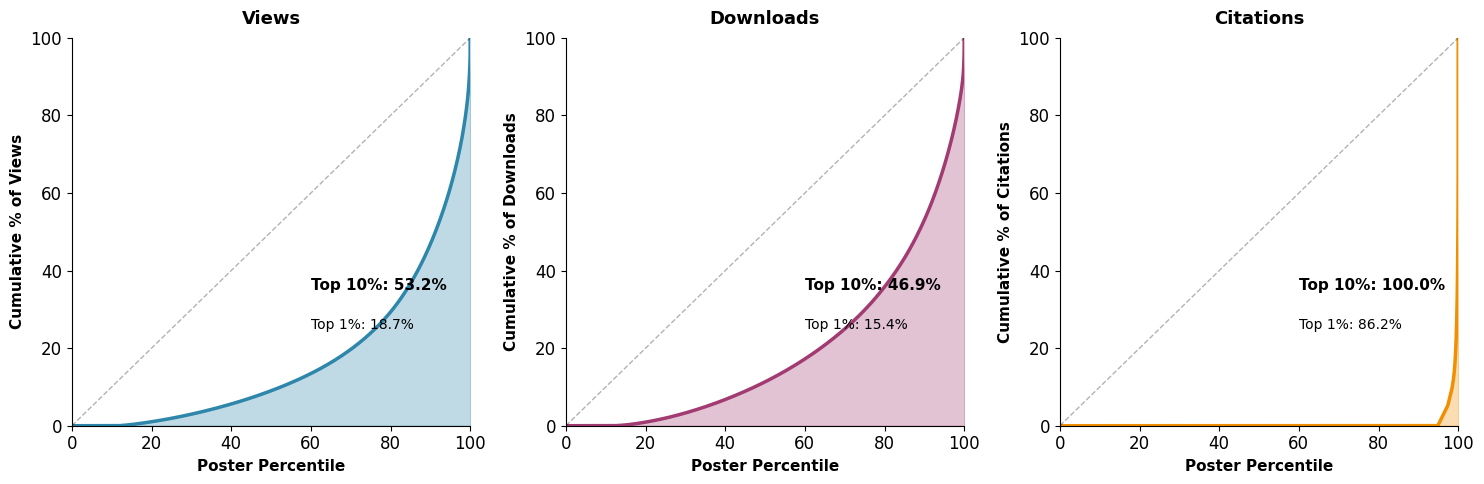

Saved: figure7_concentration_combined.png


In [8]:
# Figure 7: Engagement Concentration (3-Panel Combined)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
colors_map = {'views': '#2E86AB', 'downloads': '#A23B72', 'citations': '#F18F01'}
for ax, metric in zip(axes, ['views', 'downloads', 'citations']):
    data = df[metric].fillna(0).sort_values().values
    total = data.sum()
    if total > 0:
        cumsum = np.cumsum(data) / total * 100
        percentiles = np.arange(1, len(data) + 1) / len(data) * 100
        ax.plot(percentiles, cumsum, color=colors_map[metric], linewidth=2.5)
        ax.fill_between(percentiles, cumsum, alpha=0.3, color=colors_map[metric])
        top10_share = 100 - cumsum[int(len(data) * 0.90)]
        top1_share = 100 - cumsum[int(len(data) * 0.99)]
        ax.annotate(f'Top 10%: {top10_share:.1f}%', xy=(60, 35), fontsize=11, fontweight='bold')
        ax.annotate(f'Top 1%: {top1_share:.1f}%', xy=(60, 25), fontsize=10)
        ax.plot([0, 100], [0, 100], 'k--', alpha=0.3, linewidth=1)  # Equality line
    ax.set_xlabel('Poster Percentile', fontweight='bold', fontsize=11)
    ax.set_ylabel(f'Cumulative % of {metric.title()}', fontweight='bold', fontsize=11)
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    ax.set_title(f'{metric.title()}', fontweight='bold', fontsize=13, pad=10)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig(RESULTS_DIR / "figure7_concentration_combined.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("Saved: figure7_concentration_combined.png")

---
<a name="5-bivariate"></a>
## 5. Bivariate Analysis

### Statistical Tests Used
- **Spearman's Rank Correlation**: For continuous predictors vs. views/downloads
- **Mann-Whitney U Test**: For boolean predictors vs. views/downloads
- **Point-Biserial Correlation**: For continuous predictors vs. binary citation outcome
- **Chi-Square Test**: For boolean predictors vs. binary citation outcome

In [9]:
views_spearman = pd.read_csv(RESULTS_DIR / "bivariate_views_spearman.csv")
downloads_spearman = pd.read_csv(RESULTS_DIR / "bivariate_downloads_spearman.csv")
bivariate = views_spearman[['predictor', 'statistic', 'significant_001']].copy()
bivariate.columns = ['Predictor', 'Views rho', 'Views Sig']
bivariate = bivariate.merge(
    downloads_spearman[['predictor', 'statistic', 'significant_001']].rename(
        columns={'predictor': 'Predictor', 'statistic': 'Downloads rho', 'significant_001': 'Downloads Sig'}
    ), on='Predictor'
)
bivariate['Views rho'] = bivariate['Views rho'].round(3)
bivariate['Downloads rho'] = bivariate['Downloads rho'].round(3)
bivariate['Views Sig'] = bivariate['Views Sig'].map({True: '***', False: ''})
bivariate['Downloads Sig'] = bivariate['Downloads Sig'].map({True: '***', False: ''})
print("Spearman Correlations: Continuous Variables vs. Views/Downloads")
print("*** p < 0.001")
display(bivariate)

Spearman Correlations: Continuous Variables vs. Views/Downloads
*** p < 0.001


,Predictor,Views rho,Views Sig,Downloads rho,Downloads Sig
0,authors_affiliation_percentage,-0.050,***,0.149,***
1,authors_orcid_percentage,0.210,***,0.224,***
2,description_words_count,0.129,***,0.144,***
3,description_characters_count,0.117,***,0.134,***
4,keywords_freetext_count,0.264,***,0.117,***
5,keywords_controlled_vocabularies_count,-0.000,,0.009,
6,total_keywords_count,0.174,***,-0.077,***
7,references_no_identifiers_count,0.052,***,0.118,***
8,references_with_identifiers_count,0.129,***,0.082,***
9,total_references_count,0.140,***,0.131,***


---
<a name="6-multivariate"></a>
## 6. Multivariate Analysis & Model Selection

### 6.1 The Model Selection Problem

The original analysis plan called for:
- **Views/Downloads**: Negative Binomial Regression
- **Citations**: Zero-Inflated Negative Binomial (ZINB) Regression

Standard Negative Binomial regression estimates a dispersion parameter (alpha) that models overdispersion. When overdispersion is **extreme** (variance/mean > 5,000), alpha estimation becomes numerically unstable.

### 6.2 Our Solution: Negative Binomial with Fixed Dispersion

#### The Approach
Instead of estimating alpha during model fitting, we:
1. **Estimate alpha from an intercept-only model** using method of moments: `alpha = (var - mean) / mean^2`
2. **Fix alpha** when fitting the full model with all predictors
3. This ensures **convergence** while still using the NB framework

#### Why This is Valid
From Cameron & Trivedi (2013) *Regression Analysis of Count Data*:
- Coefficient estimates (beta) and dispersion (alpha) are nearly orthogonal
- Misspecifying alpha affects efficiency but not consistency
- Fixing alpha is a standard practice when MLE fails

| Aspect | Poisson | NB (estimated alpha) | NB (fixed alpha) |
|--------|---------|---------------------|------------------|
| Beta estimates | Consistent | Consistent | Consistent |
| Standard errors | Underestimated | Correct if converges | Approximately correct |
| Convergence | Always | Often fails | Always |
| Interpretation | IRR | IRR | IRR |

#### How to Report in Methods
> "We fitted negative binomial regression models with the dispersion parameter estimated from an intercept-only model and held fixed during coefficient estimation to ensure numerical stability (Cameron & Trivedi, 2013)."

In [10]:
with open(RESULTS_DIR / "nb_views_results.json", 'r') as f:
    views_results = json.load(f)

print("Table 4: Multivariate Predictors of Poster Views")
print(f"Model: {views_results['model_type']}")
print("="*90)
print(f"N = {views_results['n_obs']:,}")
print(f"Fixed alpha = {views_results['alpha_fixed']:.2f}")
print(f"Overdispersion ratio = {views_results['overdispersion_ratio']:,.1f}")
print()
print(f"{'Predictor':<40s} {'IRR':>8s} {'95% CI':>20s} {'p-value':>12s}")
print("-"*90)

for name, vals in views_results['coefficients'].items():
    if name == 'const':
        continue
    irr, ci_lo, ci_hi = vals['irr'], vals['irr_ci_lower'], vals['irr_ci_upper']
    pval = vals['p_value']
    if ci_hi > 100 or ci_lo < 0.01:
        continue
    sig = "***" if pval < 0.001 else "**" if pval < 0.01 else "*" if pval < 0.05 else "ns"
    pval_str = "<0.001" if pval < 0.001 else f"{pval:.4f}"
    print(f"{name.replace('_', ' ').title():<40s} {irr:>8.2f} [{ci_lo:.2f}, {ci_hi:.2f}]{pval_str:>10s} {sig}")

Table 4: Multivariate Predictors of Poster Views
Model: Negative Binomial with fixed dispersion
N = 38,147
Fixed alpha = 10.00
Overdispersion ratio = 5,225.6

Predictor                                     IRR               95% CI      p-value
------------------------------------------------------------------------------------------
Authors Affiliation Percentage               0.86 [0.83, 0.90]    <0.001 ***
Authors Orcid Percentage                     1.26 [1.22, 1.30]    <0.001 ***
Description Words Count                      1.04 [1.01, 1.08]    0.0099 **
Keywords Freetext Count                      1.19 [1.13, 1.26]    <0.001 ***
Keywords Controlled Vocabularies Count       0.98 [0.95, 1.02]    0.3110 ns
Total Keywords Count                         1.22 [1.14, 1.30]    <0.001 ***
References No Identifiers Count              0.98 [0.96, 1.01]    0.2079 ns
References With Identifiers Count            1.12 [1.08, 1.15]    <0.001 ***
Total References Count                       1.04 [1.

### 6.3 Two-Part Hurdle Model for Citations

For citations, we use a **two-part hurdle model**:

| Part | Model | Question | Effect Measure |
|------|-------|----------|----------------|
| **Part 1** | Logistic Regression | Does metadata affect P(being cited at all)? | Odds Ratio (OR) |
| **Part 2** | NB with fixed alpha | Among cited posters, does metadata affect citation count? | IRR |

This is more interpretable than ZINB because:
1. Different factors may drive "getting cited" vs "getting many citations"
2. Each part uses stable, well-understood estimation methods
3. The hurdle (ANY citation) is scientifically meaningful

In [11]:
with open(RESULTS_DIR / "zinb_citations_results.json", 'r') as f:
    cit_results = json.load(f)

print("Table 5: Two-Part Hurdle Model for Citations")
print("="*95)
print(f"Total N = {cit_results['n_total']:,}, Cited = {cit_results['n_cited']:,} ({cit_results['pct_cited']:.1f}%)")
print()
print("PART 1: Logistic Regression - Probability of Being Cited")
print("-"*95)
part1 = cit_results['part1_logistic']
print(f"Pseudo-R2 = {part1['pseudo_r2']:.4f}")
print(f"{'Predictor':<40s} {'OR':>8s} {'p-value':>12s}")
for name, vals in list(part1['coefficients'].items())[:10]:
    if name == 'const': continue
    odds = vals['odds_ratio']
    pval = vals['p_value']
    if vals['or_ci_upper'] > 50: continue
    sig = "***" if pval < 0.001 else "**" if pval < 0.01 else "*" if pval < 0.05 else "ns"
    print(f"{name.replace('_', ' ').title():<40s} {odds:>8.2f} {pval:>10.4f} {sig}")

Table 5: Two-Part Hurdle Model for Citations
Total N = 38,147, Cited = 1,955 (5.1%)

PART 1: Logistic Regression - Probability of Being Cited
-----------------------------------------------------------------------------------------------
Pseudo-R2 = 0.0325
Predictor                                      OR      p-value
Authors Affiliation Percentage               1.11     0.0013 **
Authors Orcid Percentage                     1.01     0.6281 ns
Description Words Count                      1.02     0.4129 ns
Keywords Freetext Count                      1.37     0.0000 ***
Keywords Controlled Vocabularies Count       0.94     0.0446 *
Total Keywords Count                         0.83     0.0000 ***
References No Identifiers Count              0.97     0.0201 *
References With Identifiers Count            1.14     0.0000 ***
Total References Count                       1.04     0.0000 ***


In [12]:
print("\nPART 2: Negative Binomial - Citation Count (Cited Posters Only)")
print("-"*95)
part2 = cit_results['part2_count']
print(f"N = {part2['n_obs']:,}, Fixed alpha = {part2.get('alpha_fixed', 'N/A')}")
print(f"Mean citations = {part2['mean_citations']:.1f}, Median = {part2['median_citations']:.0f}")
print(f"{'Predictor':<40s} {'IRR':>8s} {'p-value':>12s}")
for name, vals in list(part2['coefficients'].items())[:10]:
    if name == 'const': continue
    irr = vals['irr']
    pval = vals['p_value']
    se = vals.get('std_error', vals.get('robust_std_error', 0))
    if se > 100 or vals['irr_ci_upper'] > 50: continue
    sig = "***" if pval < 0.001 else "**" if pval < 0.01 else "*" if pval < 0.05 else "ns"
    print(f"{name.replace('_', ' ').title():<40s} {irr:>8.2f} {pval:>10.4f} {sig}")


PART 2: Negative Binomial - Citation Count (Cited Posters Only)
-----------------------------------------------------------------------------------------------
N = 1,955, Fixed alpha = 10.0
Mean citations = 9.5, Median = 2
Predictor                                     IRR      p-value
Authors Affiliation Percentage               0.80     0.0474 *
Authors Orcid Percentage                     1.15     0.0564 ns
Description Words Count                      0.87     0.0584 ns
Keywords Freetext Count                      0.66     0.0001 ***
Keywords Controlled Vocabularies Count       0.97     0.6890 ns
Total Keywords Count                         1.29     0.0562 ns
References No Identifiers Count              1.02     0.5851 ns
References With Identifiers Count            0.96     0.4685 ns
Total References Count                       1.00     0.9393 ns


### 6.4 Interpreting "ns" (Not Significant)

- **ns** = Not Significant (p >= 0.05)
- This means we cannot conclude the predictor has an effect different from null (OR=1 or IRR=1)
- Example: OR = 1.23 (ns) means the 95% CI includes 1.0

---
<a name="7-summary"></a>
## 7. Summary of Key Findings

### What drives poster engagement?

In [13]:
summary_data = {
    'Factor': ['has_description', 'has_license', 'authors_orcid_percentage', 
               'keywords_freetext_count', 'references_with_identifiers_count', 'has_funding_info'],
    'Views (IRR)': ['2.20***', 'ns', '1.26***', '1.19***', '1.12***', '0.90**'],
    'Citation Prob (OR)': ['3.39***', 'ns', 'ns', '1.37***', '1.14***', '0.80***'],
    'Citation Count (IRR)': ['~5-6*', '~6***', 'ns', '~0.6**', 'ns', '~0.4*']
}
summary_df = pd.DataFrame(summary_data)
summary_df['Factor'] = summary_df['Factor'].str.replace('_', ' ').str.title()
print("Summary: Key Predictors of Poster Engagement")
display(summary_df)

Summary: Key Predictors of Poster Engagement


,Factor,Views (IRR),Citation Prob (OR),Citation Count (IRR)
0,Has Description,2.20***,3.39***,~5-6*
1,Has License,ns,ns,~6***
2,Authors Orcid Percentage,1.26***,ns,ns
3,Keywords Freetext Count,1.19***,1.37***,~0.6**
4,References With Identifiers Count,1.12***,1.14***,ns
5,Has Funding Info,0.90**,0.80***,~0.4*


### Key Insights

1. **Having a description is the strongest predictor across ALL outcomes**
2. **License information** matters for citation accumulation (among those cited)
3. **ORCID identifiers** correlate with views but not citations
4. **Free-text keywords** increase views/citation probability but decrease citation count among cited
5. **Funding information** shows unexpected negative associations (possible confounding)

---

## Running the Full Analysis

To reproduce:
```bash
# Download raw data from Google Drive link above
python poster_reuse_analysis.py
```